In [ ]:
import os
import subprocess
import matplotlib.pyplot as plt
import matplotlib as mpl
from upsetplot import UpSet, from_contents
import pyfastx

import varseek as vk
from varseek.utils import get_set_of_headers_from_sam, download_ensembl_reference_files, download_t2t_reference_files

# Set global settings
plt.rcParams.update(
    {
        "savefig.dpi": 450,  # Set resolution to 450 dpi
        "font.family": "DejaVu Sans",  # Set font to Arial  # TODO: replace with Arial for Nature
        "pdf.fonttype": 42,  # Embed fonts as TrueType (keeps text editable)
        "ps.fonttype": 42,  # Same for PostScript files
        "savefig.format": "pdf",  # Default save format as PNG
        "savefig.bbox": "tight",  # Adjust bounding box to fit tightly
        "figure.facecolor": "white",  # Set figure background to white (common for RGB)
        "savefig.transparent": False,  # Disable transparency
    }
)

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
SAVE_PDF_GLOBAL = os.getenv("VARSEEK_SAVE_PDF") == "TRUE"
DPI = 450

23:15:33 - INFO - Old pandas version detected. Patching DataFrame.map to DataFrame.applymap


In [ ]:
w = 55
k = 59
threads = 4
ensembl_version_dlist_grch37 = 113
ensembl_version_dlist_grch38 = 113

# File/directory paths - created if they do not exist
reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
output_dir = os.path.join(RLSRWP_2025_dir, "data", "dlist_figs")
vcrs_fasta = os.path.join(output_dir, "vk_build_out_dir", "vcrs.fa")
bowtie_reference_folder_parent = os.path.join(output_dir, "bowtie_tests")
plot_out_dir = os.path.join(output_dir, "reference_dlist_comparison")

In [4]:
if not os.path.exists(vcrs_fasta):
    vk_build_out_dir = os.path.dirname(vcrs_fasta) if os.path.dirname(vcrs_fasta) else "."
    vk.build(
        variants="cosmic_cmc",
        sequences="cdna",
        out=vk_build_out_dir,
        vcrs_fasta_out=vcrs_fasta,
        k=k,
        w=w
    )

In [5]:
def run_bowtie_build(bowtie2_build, threads, reference_fasta, bowtie_reference_folder, dry_run = False):
    bowtie_genome_build_command = f"{bowtie2_build} --threads {threads} {reference_fasta} {bowtie_reference_folder}"
    if dry_run:
        print(bowtie_genome_build_command, "&& \\")
        return
    result = subprocess.run(bowtie_genome_build_command, shell=True, check=True)
    return result

def run_bowtie_align(bowtie2, threads, k, bowtie_reference_folder, vcrs_fasta, output_sam_file, dry_run):
    bowtie_genome_align_command = f"{bowtie2} -a -f -p {threads} --xeq --score-min C,0,0 --np 1 --n-ceil C,0,0 -F {k},1 -R 1 -N 0 -L 31 -i C,1,0 --no-1mm-upfront --no-unal -x {bowtie_reference_folder} -U {vcrs_fasta} -S {output_sam_file}"
    if dry_run:
        print(bowtie_genome_align_command, "&& \\")
        return
    result = subprocess.run(bowtie_genome_align_command, shell=True, check=True)
    return result

def create_header_and_sequence_set(dlist_fasta_file):
    header_and_sequence_set = set()
    for header, sequence in pyfastx.Fastx(dlist_fasta_file):
        header_and_sequence_entry = header + "_" + sequence
        header_and_sequence_set.add(header_and_sequence_entry)
    return header_and_sequence_set

def save_set(set_name, file_path):
    with open(file_path, "w") as file:
        for item in set_name:
            file.write(f"{item}\n")

def read_set(file_path):
    with open(file_path, "r") as file:
        return {line.strip() for line in file}

def run_full_alignment_workflow(bowtie_reference_folder_parent, vcrs_fasta, reference_source, reference_dir = None, dfk_length = None, threads = 2, k = 31, release = None, dry_run = False):
    print(f"Running full alignment workflow for {reference_source} reference")
    bowtie2_build = "bowtie2-build"
    bowtie2 = "bowtie2"

    if reference_dir is None:
        reference_dir = bowtie_reference_folder_parent

    os.makedirs(bowtie_reference_folder_parent, exist_ok=True)
    os.makedirs(reference_dir, exist_ok=True)

    if dfk_length is None:
        dfk_length = k + 2
    
    bowtie_genome_reference_folder = f"{bowtie_reference_folder_parent}/{reference_source}_genome_bowtie_reference/index"
    bowtie_cdna_reference_folder = f"{bowtie_reference_folder_parent}/{reference_source}_transcriptome_bowtie_reference/index"
    os.makedirs(os.path.dirname(bowtie_genome_reference_folder), exist_ok=True)
    os.makedirs(os.path.dirname(bowtie_cdna_reference_folder), exist_ok=True)
    genome_sam_file = f"{bowtie_reference_folder_parent}/VCRSs_to_{reference_source}_index_genome/output.sam"
    cdna_sam_file = f"{bowtie_reference_folder_parent}/VCRSs_to_{reference_source}_index_cdna/output.sam"
    os.makedirs(os.path.dirname(genome_sam_file), exist_ok=True)
    os.makedirs(os.path.dirname(cdna_sam_file), exist_ok=True)

    dlist_fasta_file_genome = f"{bowtie_reference_folder_parent}/VCRSs_to_{reference_source}_index_genome/dlist.fasta"
    dlist_fasta_file_cdna = f"{bowtie_reference_folder_parent}/VCRSs_to_{reference_source}_index_cdna/dlist.fasta"
    os.makedirs(os.path.dirname(dlist_fasta_file_genome), exist_ok=True)
    os.makedirs(os.path.dirname(dlist_fasta_file_cdna), exist_ok=True)

    if reference_source == "grch37":
        human_reference_for_dlist_folder = os.path.join(reference_dir, f"ensembl_grch37_release{release}")  # matches vk build
        genome_fasta, cdna_fasta, gtf_file = download_ensembl_reference_files(human_reference_for_dlist_folder, grch=37, ensembl_release=release)

    elif reference_source == "grch38":
        human_reference_for_dlist_folder = os.path.join(reference_dir, f"ensembl_grch38_release{release}")  # matches vk build
        genome_fasta, cdna_fasta, gtf_file = download_ensembl_reference_files(human_reference_for_dlist_folder, grch=38, ensembl_release=release)
    
    elif reference_source == "t2t":
        human_reference_for_dlist_folder = os.path.join(reference_dir, "t2t")
        genome_fasta, cdna_fasta, gtf_file = download_t2t_reference_files(human_reference_for_dlist_folder)
    
    else:
        raise ValueError("Release must be either grch37, grch38, or t2t")

    if not os.path.exists(f"{bowtie_genome_reference_folder}.1.bt2"):
        print("Building bowtie index for genome reference")
        result = run_bowtie_build(bowtie2_build = bowtie2_build, threads = threads, reference_fasta = genome_fasta, bowtie_reference_folder = bowtie_genome_reference_folder, dry_run = dry_run)

    if not os.path.exists(genome_sam_file):
        print("Aligning reads to genome reference")
        result = run_bowtie_align(bowtie2 = bowtie2, threads = threads, k = k, bowtie_reference_folder = bowtie_genome_reference_folder, vcrs_fasta = vcrs_fasta, output_sam_file = genome_sam_file, dry_run = dry_run)
    
    # if not os.path.exists(dlist_fasta_file_genome) and not dry_run:
    #     parse_sam_and_extract_sequences(genome_sam_file, genome_fasta, dlist_fasta_file_genome, k = k, dfk_length = dfk_length, capitalize = True, remove_duplicates = False)

    if not os.path.exists(f"{bowtie_cdna_reference_folder}.1.bt2"):
        print("Building bowtie index for cDNA reference")
        result = run_bowtie_build(bowtie2_build = bowtie2_build, threads = threads, reference_fasta = cdna_fasta, bowtie_reference_folder = bowtie_cdna_reference_folder, dry_run = dry_run)

    if not os.path.exists(cdna_sam_file):
        print("Aligning reads to cDNA reference")
        result = run_bowtie_align(bowtie2 = bowtie2, threads = threads, k = k, bowtie_reference_folder = bowtie_cdna_reference_folder, vcrs_fasta = vcrs_fasta, output_sam_file = cdna_sam_file, dry_run = dry_run)

    # if not os.path.exists(dlist_fasta_file_cdna) and not dry_run:
    #     parse_sam_and_extract_sequences(cdna_sam_file, cdna_fasta, dlist_fasta_file_cdna, k = k, dfk_length = dfk_length, capitalize = True, remove_duplicates = False)
        
    if dry_run:
        return "", "", "", ""
    
    print("Getting header set genome")
    header_set_genome = get_set_of_headers_from_sam(genome_sam_file, k = k)
    print("Getting header set cDNA")
    header_set_cdna = get_set_of_headers_from_sam(cdna_sam_file, k = k)

    # header_and_sequence_set_genome = create_header_and_sequence_set(dlist_fasta_file_genome)
    # header_and_sequence_set_cdna = create_header_and_sequence_set(dlist_fasta_file_cdna)

    set_parent = f"{bowtie_reference_folder_parent}/sets"
    os.makedirs(set_parent, exist_ok = True)
    save_set(header_set_genome, f"{set_parent}/{reference_source}_header_set_genome.txt")
    save_set(header_set_cdna, f"{set_parent}/{reference_source}_header_set_cdna.txt")
    # save_set(header_and_sequence_set_genome, f"{set_parent}/{reference_source}_header_and_sequence_set_genome.txt")
    # save_set(header_and_sequence_set_cdna, f"{set_parent}/{reference_source}_header_and_sequence_set_cdna.txt")

    return header_set_genome, header_set_cdna  # , header_and_sequence_set_genome, header_and_sequence_set_cdna




def show_upset_within_references(header_set_genome, header_set_cdna, title = "", save_path=None):
    upset_data_dict = from_contents(
        {"genome": header_set_genome, "cdna": header_set_cdna}
    )

    upset_plot = UpSet(upset_data_dict, subset_size="count", show_counts=True, show_percentages=True)

    mpl.rcParams['font.size'] = 7

    upset_plot.plot()
    plt.suptitle(title)
    
    header_set_genome_combined = header_set_genome | header_set_cdna
    plt.text(0, 0.5, f"Union: {len(header_set_genome_combined)}", fontsize=7, transform=plt.gcf().transFigure)

    if save_path:
        plt.savefig(save_path, format="png", dpi=DPI, bbox_inches="tight")
        if SAVE_PDF_GLOBAL:
            plt.savefig(save_path.replace(".png", ".pdf"), format="pdf", dpi=DPI)

    plt.show()

    return upset_plot

def show_upset_between_references(header_set_genome_t2t, header_set_genome_grch38, header_set_genome_grch37, data_type, title = None, save_path=None):
    upset_data_dict = from_contents(
        {f"T2T_{data_type}": header_set_genome_t2t, f"GRCh38_{data_type}": header_set_genome_grch38, f"GRCh37_{data_type}": header_set_genome_grch37}
    )

    upset_plot = UpSet(upset_data_dict, subset_size="count", show_counts=True, show_percentages=True)

    mpl.rcParams['font.size'] = 7

    if title is None:
        title = f"T2T vs GRCh38 vs GRCh37: {data_type}"

    upset_plot.plot()
    plt.suptitle(title)

    if save_path:
        plt.savefig(save_path, format="png", dpi=DPI, bbox_inches="tight")
        if SAVE_PDF_GLOBAL:
            plt.savefig(save_path.replace(".png", ".pdf"), format="pdf", dpi=DPI)

    plt.show()

    return upset_plot

In [6]:
header_set_genome_t2t_path = f"{bowtie_reference_folder_parent}/sets/t2t_header_set_genome.txt"
header_set_cdna_t2t_path = f"{bowtie_reference_folder_parent}/sets/t2t_header_set_cdna.txt"

header_set_genome_grch38_path = f"{bowtie_reference_folder_parent}/sets/grch38_header_set_genome.txt"
header_set_cdna_grch38_path = f"{bowtie_reference_folder_parent}/sets/grch38_header_set_cdna.txt"

header_set_genome_grch37_path = f"{bowtie_reference_folder_parent}/sets/grch37_header_set_genome.txt"
header_set_cdna_grch37_path = f"{bowtie_reference_folder_parent}/sets/grch37_header_set_cdna.txt"

In [ ]:
if not os.path.exists(header_set_genome_t2t_path) or not os.path.exists(header_set_cdna_t2t_path):
    header_set_genome_t2t, header_set_cdna_t2t = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, vcrs_fasta = vcrs_fasta, reference_dir = reference_dir, reference_source = "t2t", release = None, threads = threads, k = k)
else:
    header_set_genome_t2t = read_set(header_set_genome_t2t_path)
    header_set_cdna_t2t = read_set(header_set_cdna_t2t_path)

if not os.path.exists(header_set_genome_grch38_path) or not os.path.exists(header_set_cdna_grch38_path):
    header_set_genome_grch38, header_set_cdna_grch38 = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, vcrs_fasta = vcrs_fasta, reference_dir = reference_dir, reference_source = "grch38", release = ensembl_version_dlist_grch38, threads = threads, k = k)
else:
    header_set_genome_grch38 = read_set(header_set_genome_grch38_path)
    header_set_cdna_grch38 = read_set(header_set_cdna_grch38_path)

if not os.path.exists(header_set_genome_grch37_path) or not os.path.exists(header_set_cdna_grch37_path):
    header_set_genome_grch37, header_set_cdna_grch37 = run_full_alignment_workflow(bowtie_reference_folder_parent = bowtie_reference_folder_parent, vcrs_fasta = vcrs_fasta, reference_dir = reference_dir, reference_source = "grch37", release = ensembl_version_dlist_grch37, threads = threads, k = k)
else:
    header_set_genome_grch37 = read_set(header_set_genome_grch37_path)
    header_set_cdna_grch37 = read_set(header_set_cdna_grch37_path)

In [8]:
header_set_t2t = header_set_genome_t2t | header_set_cdna_t2t
header_set_grch38 = header_set_genome_grch38 | header_set_cdna_grch38
header_set_grch37 = header_set_genome_grch37 | header_set_cdna_grch37

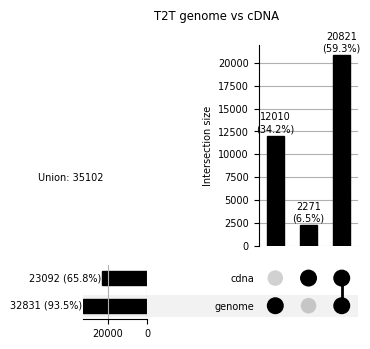

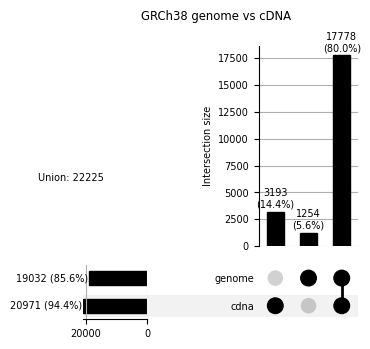

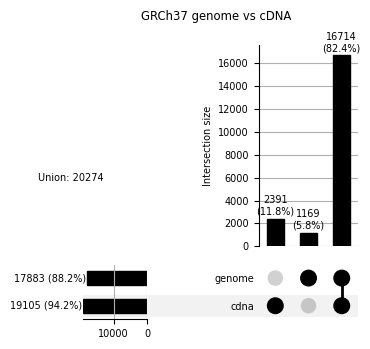

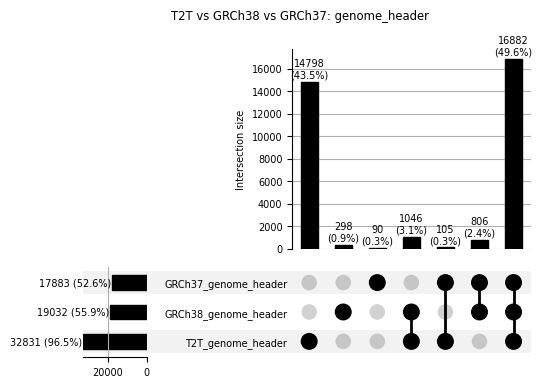

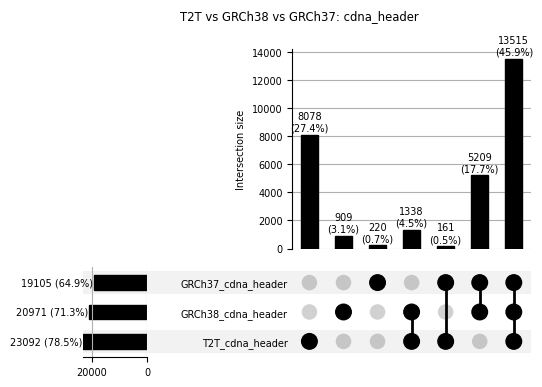

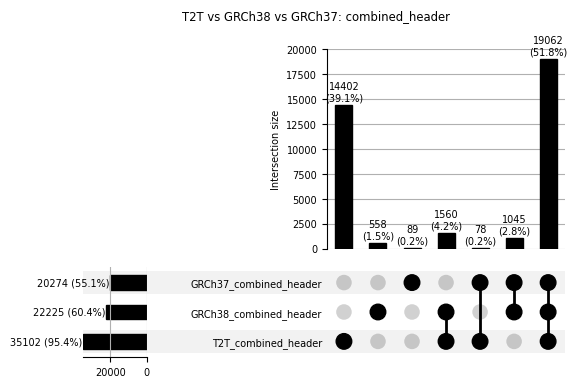

In [9]:
os.makedirs(plot_out_dir, exist_ok=True)

t2t_upset_plot = show_upset_within_references(header_set_genome_t2t, header_set_cdna_t2t, title = "T2T genome vs cDNA", save_path=f"{plot_out_dir}/t2t_genome_vs_cdna.png")
grch38_upset_plot = show_upset_within_references(header_set_genome_grch38, header_set_cdna_grch38, title = "GRCh38 genome vs cDNA", save_path=f"{plot_out_dir}/grch38_genome_vs_cdna.png")
grch37_upset_plot = show_upset_within_references(header_set_genome_grch37, header_set_cdna_grch37, title = "GRCh37 genome vs cDNA", save_path=f"{plot_out_dir}/grch37_genome_vs_cdna.png")

genome_upset_plot = show_upset_between_references(header_set_genome_t2t, header_set_genome_grch38, header_set_genome_grch37, "genome_header", save_path=f"{plot_out_dir}/genome_header.png")
cdna_upset_plot = show_upset_between_references(header_set_cdna_t2t, header_set_cdna_grch38, header_set_cdna_grch37, "cdna_header", save_path=f"{plot_out_dir}/cdna_header.png")
combined_upset_plot = show_upset_between_references(header_set_t2t, header_set_grch38, header_set_grch37, "combined_header", save_path=f"{plot_out_dir}/combined_header.png")